[paper](https://www.nature.com/articles/s41746-020-00372-6.pdf)  
[dataset](https://github.com/nshomron/covidpred)

## 1. Data Preprocessing

In [293]:
# # 安裝會使用到的套件
# !pip install xgboost
# !pip install imblearn

In [294]:
# 確認當前工作目錄
%pwd

'c:\\Users\\betty\\D\\資管所\\Data_Mining\\project\\mid'

In [295]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import metrics, ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import seaborn as sns
import time

In [296]:
metadata = pd.read_csv("covid.csv") #匯資料
metadata.head(3)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020/3/31,0,0,0,0,0,negative,No,male,Other
1,2020/3/31,0,0,0,0,0,negative,No,female,Other
2,2020/3/31,0,0,0,0,0,negative,No,male,Other


In [297]:
# # 增加id
# metadata=metadata.assign(cov_id=metadata.index)

In [298]:
# 共有 278848 筆資料
metadata.shape

(53843, 10)

每個 class 的數量

In [299]:
fre=metadata['corona_result'].value_counts()
print(fre)

negative    48225
positive     4795
other         823
Name: corona_result, dtype: int64


In [300]:
metadata['cough']=metadata['cough'].replace('None',np.nan)
metadata['fever']=metadata['fever'].replace('None',np.nan)
metadata['sore_throat']=metadata['sore_throat'].replace('None',np.nan)
metadata['shortness_of_breath']=metadata['shortness_of_breath'].replace('None',np.nan)
metadata['head_ache']=metadata['head_ache'].replace('None',np.nan)
metadata['gender']=metadata['gender'].replace(['female', 'male', 'None'], [0, 1, np.nan])
metadata['age_60_and_above']=metadata['age_60_and_above'].replace(['None', 'No', 'Yes'], [np.nan, 0 ,1])
metadata['test_indication']=metadata['test_indication'].replace(['Contact with confirmed', 'Other', 'Abroad'], [1, 0,0])
metadata['corona_result']=metadata['corona_result'].replace(['negative', 'positive'], [0, 1])

metadata

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020/3/31,0,0,0,0,0,0,0,1.0,0
1,2020/3/31,0,0,0,0,0,0,0,0.0,0
2,2020/3/31,0,0,0,0,0,0,0,1.0,0
3,2020/3/31,0,0,0,0,0,1,0,0.0,0
4,2020/3/31,1,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
53838,2020/3/22,1,1,0,0,0,0,1,0.0,0
53839,2020/3/22,1,1,1,0,1,0,0,0.0,0
53840,2020/3/22,1,0,0,0,0,0,0,0.0,0
53841,2020/3/22,1,0,0,0,0,0,0,1.0,0


In [301]:
# drop_na=metadata.dropna()
# print(metadata[metadata['cough']==np.nan].count())
# print(metadata[metadata['fever']==np.nan])
# print(metadata[metadata['sore_throat']==np.nan])
# print(metadata[metadata['shortness_of_breath']==np.nan])
# print(metadata[metadata['head_ache']==np.nan])
# print(metadata[metadata['age_60_and_above']==np.nan])
# print(metadata[metadata['gender']==np.nan])

metadata.isnull().sum()

test_date                 0
cough                    16
fever                    17
sore_throat               0
shortness_of_breath       0
head_ache                 0
corona_result             0
age_60_and_above          0
gender                 1194
test_indication           0
dtype: int64

In [302]:
print(metadata["cough"].value_counts())
print(metadata["fever"].value_counts())
print(metadata["sore_throat"].value_counts())
print(metadata["shortness_of_breath"].value_counts())
print(metadata["head_ache"].value_counts())
print(metadata["gender"].value_counts())
print(metadata["age_60_and_above"].value_counts())
print(metadata["test_indication"].value_counts())
print(metadata['corona_result'].value_counts())

0    45773
1     8054
Name: cough, dtype: int64
0    49032
1     4794
Name: fever, dtype: int64
0    53021
1      822
Name: sore_throat, dtype: int64
0    53189
1      654
Name: shortness_of_breath, dtype: int64
0    52648
1     1195
Name: head_ache, dtype: int64
0.0    26436
1.0    26213
Name: gender, dtype: int64
0    45994
1     7849
Name: age_60_and_above, dtype: int64
0    50743
1     3100
Name: test_indication, dtype: int64
0        48225
1         4795
other      823
Name: corona_result, dtype: int64


In [303]:
remove=metadata
remove.drop(remove[remove['corona_result']=='other'].index, inplace=True)

age_60_and_above的空值將近50%，欄位值為 0 或 1，以 random 填空值

In [304]:
drop_na = remove
np.random.seed(2022)
drop_na.age_60_and_above.fillna(np.random.randint(0, 1), inplace =True)
drop_na.cough.fillna(np.random.randint(0, 1), inplace =True)
drop_na.fever.fillna(np.random.randint(0, 1), inplace =True)
drop_na.sore_throat.fillna(np.random.randint(0, 1), inplace =True)
drop_na.shortness_of_breath.fillna(np.random.randint(0, 1), inplace =True)
drop_na.head_ache.fillna(np.random.randint(0, 1), inplace =True)
drop_na.gender.fillna(np.random.randint(0, 1), inplace =True)
drop_na.test_indication.fillna(np.random.randint(0, 1), inplace =True)
# drop_na.age_60_and_above.fillna()
drop_na.isnull().sum()
# drop_na.shape

test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
corona_result          0
age_60_and_above       0
gender                 0
test_indication        0
dtype: int64

In [305]:
drop_na["cough"] = pd.to_numeric(drop_na["cough"])
drop_na["fever"] = pd.to_numeric(drop_na["fever"])
drop_na["sore_throat"] = pd.to_numeric(drop_na["sore_throat"])
drop_na["shortness_of_breath"] = pd.to_numeric(drop_na["shortness_of_breath"])
drop_na["head_ache"] = pd.to_numeric(drop_na["head_ache"])
drop_na["gender"] = pd.to_numeric(drop_na["gender"], downcast="integer")
drop_na["age_60_and_above"] = pd.to_numeric(drop_na["age_60_and_above"])
drop_na["test_indication"] = pd.to_numeric(drop_na["test_indication"])
drop_na["corona_result"] = pd.to_numeric(drop_na["corona_result"])

In [306]:
print(drop_na["cough"].dtypes)
print(drop_na["fever"].dtypes)
print(drop_na["sore_throat"].dtypes)
print(drop_na["shortness_of_breath"].dtypes)
print(drop_na["head_ache"].dtypes)
print(drop_na["gender"].dtypes)
print(drop_na["age_60_and_above"].dtypes)
print(drop_na["test_indication"].dtypes)
print(drop_na["corona_result"].dtypes)

int64
int64
int64
int64
int64
int8
int64
int64
int64


In [307]:
drop_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53020 entries, 0 to 53842
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   test_date            53020 non-null  object
 1   cough                53020 non-null  int64 
 2   fever                53020 non-null  int64 
 3   sore_throat          53020 non-null  int64 
 4   shortness_of_breath  53020 non-null  int64 
 5   head_ache            53020 non-null  int64 
 6   corona_result        53020 non-null  int64 
 7   age_60_and_above     53020 non-null  int64 
 8   gender               53020 non-null  int8  
 9   test_indication      53020 non-null  int64 
dtypes: int64(8), int8(1), object(1)
memory usage: 4.1+ MB


In [308]:
print(drop_na["cough"].value_counts())
print(drop_na["fever"].value_counts())
print(drop_na["sore_throat"].value_counts())
print(drop_na["shortness_of_breath"].value_counts())
print(drop_na["head_ache"].value_counts())
print(drop_na["gender"].value_counts())
print(drop_na["age_60_and_above"].value_counts())
print(drop_na["test_indication"].value_counts())
print(drop_na['corona_result'].value_counts())

0    45076
1     7944
Name: cough, dtype: int64
0    48309
1     4711
Name: fever, dtype: int64
0    52213
1      807
Name: sore_throat, dtype: int64
0    52382
1      638
Name: shortness_of_breath, dtype: int64
0    51843
1     1177
Name: head_ache, dtype: int64
0    27226
1    25794
Name: gender, dtype: int64
0    45317
1     7703
Name: age_60_and_above, dtype: int64
0    49978
1     3042
Name: test_indication, dtype: int64
0    48225
1     4795
Name: corona_result, dtype: int64


其他空值以前一個值填入

In [309]:
# drop_na.cough.fillna(method='ffill', inplace=True)
# drop_na.fever.fillna(method='ffill', inplace=True)
# drop_na.sore_throat.fillna(method='ffill', inplace=True)
# drop_na.shortness_of_breath.fillna(method='ffill', inplace=True)
# drop_na.head_ache.fillna(method='ffill', inplace=True)
# # drop_na.age_60_and_above.fillna(method='ffill', inplace=True)
# drop_na.gender.fillna(method='ffill', inplace=True)
# drop_na.test_indication.fillna(method='ffill', inplace=True)
# drop_na.isnull().sum()


## 2. Over-sampling


### 2.1 over-sampling

#### 2.1.1 all features

In [310]:
# y= drop_na.corona_result

# features_all=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
# X_all =drop_na[features_all]

In [311]:
# ros = RandomOverSampler(random_state=0)
# X_resampled_all, y_resampled_all = ros.fit_resample(X_all, y)
# from collections import Counter
# print(sorted(Counter(y_resampled_all).items()))

#### 2.1.2 filtered features

In [312]:
# features_filter=['cough', 'fever', 'age_60_and_above', 'gender', 'test_indication']
# X_filter =drop_na[features_filter]

In [313]:
# ros = RandomOverSampler(random_state=0)
# X_resampled_filter, y_resampled_filter = ros.fit_resample(X_filter, y)
# from collections import Counter
# print(sorted(Counter(y_resampled_filter).items()))

### 2.5. AdaBoost

In [314]:
# xgb = XGBClassifier(learning_rate=0.01,
#                       n_estimators=20,           # 树的个数-10棵树建立xgboost
#                       max_depth=10,               # 树的深度
#                       min_child_weight = 1,      # 叶子节点最小权重
#                       gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                       subsample=1,               # 所有样本建立决策树
#                       colsample_btree=1,         # 所有特征建立决策树
#                       scale_pos_weight=1,        # 解决样本个数不平衡的问题
#                       random_state=42,           # 随机数
#                       slient = 0
#                       )
# xgb.fit(X_train_all,y_train_all)

#### 2.5.1 AdaBoost (all)

In [315]:
# ada_all = AdaBoostClassifier(base_estimator=None, n_estimators=50,learning_rate=0.02, algorithm= "SAMME.R" ,random_state=42)

# ada_all.fit(X_train_all, y_train_all)

In [316]:
# model_type="AdaBoost (all)"
# predicted_all = ada_all.predict(X_test_all)
# predicted_prob_all = ada_all.predict_proba(X_test_all)

# # accuracy=accuracy_score(y_test, predicted)
# # confusion=confusion_matrix(y_test, predicted)

# # print("Accurracy: ", accuracy)
# # print("Confusion Matrix: ", confusion)

In [317]:
# classes = np.unique(y_test_all)
# y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

# ## Accuracy, Precision, Recall
# accuracy = metrics.accuracy_score(y_test_all, predicted_all)
# auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
#                             multi_class="ovr")
# f1=f1_score(y_test_all, predicted_all, average='weighted')
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test_all, predicted_all))
    
# ## Plot confusion matrix
# cm = metrics.confusion_matrix(y_test_all, predicted_all)
# fig, ax = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
#             cbar=False)
# ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
#        yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# ## Plot roc
# roc_auc_dict = {}
# for i in range(len(classes)):
#     fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
#                            predicted_prob_all[:,i])
#     roc_auc = metrics.auc(fpr, tpr)
#     ax[0].plot(fpr, tpr, lw=3, 
#             #   label='{0} (area={1:0.2f})'.format(classes[i], 
#             #                   metrics.auc(fpr, tpr))
#                 label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
#                )
#     roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
# ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
# ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
#           xlabel='False Positive Rate', 
#           ylabel="True Positive Rate (Recall)", 
#           title="Receiver operating characteristic")
# ax[0].legend(loc="lower right")
# ax[0].grid(True)
    
# ## Plot precision-recall curve
# for i in range(len(classes)):
#     precision, recall, thresholds = metrics.precision_recall_curve(
#                  y_test_array[:,i], predicted_prob_all[:,i])
#     ax[1].plot(recall, precision, lw=3, 
#                label='{0} (area={1:0.2f})'.format(classes[i], 
#                                   metrics.auc(recall, precision))
#               )
# ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
#           ylabel="Precision", title="Precision-Recall curve")
# ax[1].legend(loc="best")
# ax[1].grid(True)
# plt.show()

# # 把結果加進result_df
# result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1 }
#                              , ignore_index=True)
# roc_auc_all[model_type] = roc_auc

#### 2.5.2 AdaBoost (filtered)

In [318]:
# ada_filter = AdaBoostClassifier(base_estimator=None, n_estimators=50,learning_rate=0.02, algorithm= "SAMME.R" ,random_state=42)

# ada_filter.fit(X_train_filter, y_train_filter)

In [319]:
# model_type="AdaBoost (filered)"
# predicted_filter = ada_filter.predict(X_test_filter)
# predicted_prob_filter = ada_filter.predict_proba(X_test_filter)

# # accuracy=accuracy_score(y_test, predicted)
# # confusion=confusion_matrix(y_test, predicted)

# # print("Accurracy: ", accuracy)
# # print("Confusion Matrix: ", confusion)

In [320]:
# classes = np.unique(y_test_filter)
# y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

# ## Accuracy, Precision, Recall
# accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
# auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
#                             multi_class="ovr")
# f1=f1_score(y_test_filter, predicted_filter, average='weighted')
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test_filter, predicted_filter))
    
# ## Plot confusion matrix
# cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
# fig, ax = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
#             cbar=False)
# ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
#        yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# ## Plot roc
# roc_auc_dict = {}
# for i in range(len(classes)):
#     fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
#                            predicted_prob_filter[:,i])
#     roc_auc = metrics.auc(fpr, tpr)
#     ax[0].plot(fpr, tpr, lw=3, 
#             #   label='{0} (area={1:0.2f})'.format(classes[i], 
#             #                   metrics.auc(fpr, tpr))
#                 label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
#                )
#     roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
# ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
# ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
#           xlabel='False Positive Rate', 
#           ylabel="True Positive Rate (Recall)", 
#           title="Receiver operating characteristic")
# ax[0].legend(loc="lower right")
# ax[0].grid(True)
    
# ## Plot precision-recall curve
# for i in range(len(classes)):
#     precision, recall, thresholds = metrics.precision_recall_curve(
#                  y_test_array[:,i], predicted_prob_filter[:,i])
#     ax[1].plot(recall, precision, lw=3, 
#                label='{0} (area={1:0.2f})'.format(classes[i], 
#                                   metrics.auc(recall, precision))
#               )
# ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
#           ylabel="Precision", title="Precision-Recall curve")
# ax[1].legend(loc="best")
# ax[1].grid(True)
# plt.show()

# # 把結果加進result_df
# result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1}
#                              , ignore_index=True)
# roc_auc_all[model_type] = roc_auc

## 3. SMOTE

In [321]:
# drop_na[drop_na['corona_result']=='other'].count()

In [322]:
# labelencoder=LabelEncoder()
# drop_na['corona_result']=labelencoder.fit_transform(drop_na['corona_result'])

In [323]:
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC', 'F1-score','Precision','Recall'])
roc_auc_all = {}

#### 3.0.1 all features

In [324]:
y= drop_na.corona_result

features_all=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
X_all =drop_na[features_all]

In [325]:
X_resampled_all_re, y_resampled_all_re = SMOTE().fit_resample(X_all, y)
print(sorted(Counter(y_resampled_all_re).items()))

[(0, 48225), (1, 48225)]


#### 3.0.2 filtered features

In [326]:
features_filter=['cough', 'fever', 'age_60_and_above', 'gender', 'test_indication']
X_filter =drop_na[features_filter]

In [327]:
X_resampled_filter_re, y_resampled_filter_re = SMOTE().fit_resample(X_filter, y)
print(sorted(Counter(y_resampled_filter_re).items()))

[(0, 48225), (1, 48225)]


### 3.1. 根據4:1的比例切分資料集 

利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 4:1，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

#### 3.1.1 all features

In [328]:
# y= drop_na.corona_result

# features_all=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
# X_all =drop_na[features_all]

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_resampled_all_re, y_resampled_all_re, test_size=0.2, random_state=2022)

In [329]:
X_test_all

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
34771,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1
26247,0,0,0,0,0,0,1,0
18022,0,0,0,0,0,0,1,0
36027,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0
63301,0,0,1,0,0,0,1,0
26577,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0


#### 3.1.2 filtered features

In [330]:
# y= drop_na.corona_result

# features_filter=['cough', 'fever', 'age_60_and_above', 'gender', 'test_indication']
# X_filter =drop_na[features_filter]

X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_resampled_filter_re, y_resampled_filter_re, test_size=0.2, random_state=2022)

#### 3.1.3 before sampling (GradientBoost)

In [331]:
X_train_all_b, X_test_all_b, y_train_all_b, y_test_all_b = train_test_split(X_all, y, test_size=0.2, random_state=2022)

In [332]:
model_type="Gradient Boosting (all)"
gb_all = GradientBoostingClassifier()
gb_all.fit(X_train_all_b, y_train_all_b)

GradientBoostingClassifier()

In [333]:
predicted_all_b = gb_all.predict(X_test_all_b)
predicted_prob_all_b = gb_all.predict_proba(X_test_all_b)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

In [334]:
predicted_all_b.shape

(10604,)

Accuracy: 0.96
Auc: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9665
           1       0.86      0.64      0.73       939

    accuracy                           0.96     10604
   macro avg       0.91      0.82      0.86     10604
weighted avg       0.96      0.96      0.96     10604



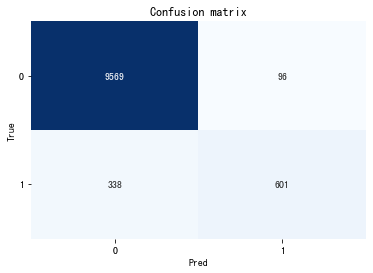

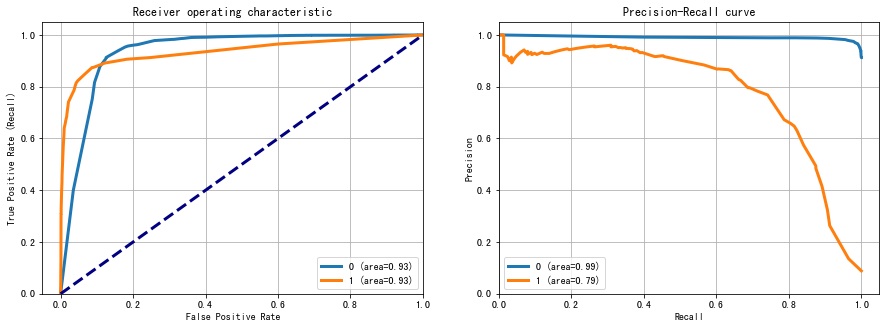

In [335]:
classes = np.unique(y_test_all_b)
y_test_array = pd.get_dummies(y_test_all_b, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all_b, predicted_all_b)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all_b,
                            multi_class="ovr")
f1 = f1_score(y_test_all_b, predicted_all_b)
precision_all = precision_score(y_test_all_b, predicted_all_b)
recall_all = recall_score(y_test_all_b, predicted_all_b)

print("Accuracy:",  round(accuracy, 2))
print("Auc:", round(auc, 2))
print("Detail:")
print(metrics.classification_report(y_test_all_b, predicted_all_b))

# Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all_b, predicted_all_b)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:, i],
                                             predicted_prob_all_b[:, i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3,
               #   label='{0} (area={1:0.2f})'.format(classes[i],
               #                   metrics.auc(fpr, tpr))
               label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc}

ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05, 1.0], ylim=[0.0, 1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

# Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:, i], predicted_prob_all_b[:, i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )
ax[1].set(xlim=[0.0, 1.05], ylim=[0.0, 1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc,
                             'F1-score': f1, 'Recall': recall_all, 'Precision': precision_all}, ignore_index=True)
roc_auc_all[model_type] = roc_auc


### 3.2. Gradient Boosting

#### 3.2.1 Gradient Boosting (all)

In [336]:
model_type="Gradient Boosting (all) SMOTE"
gb_all = GradientBoostingClassifier()
gb_all.fit(X_train_all, y_train_all)

GradientBoostingClassifier()

In [337]:
predicted_all = gb_all.predict(X_test_all)
predicted_prob_all = gb_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

##### 3.2.1.1 False Negative

In [338]:
result_all=X_test_all.copy()
result_all["corona_result"]=y_test_all
X_test_all

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
34771,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1
26247,0,0,0,0,0,0,1,0
18022,0,0,0,0,0,0,1,0
36027,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0
63301,0,0,1,0,0,0,1,0
26577,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0


In [339]:
result_all["gb_all"]=predicted_all
result_all

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,gb_all
34771,0,0,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1,1,1
26247,0,0,0,0,0,0,1,0,0,0
18022,0,0,0,0,0,0,1,0,0,0
36027,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0,0,0
63301,0,0,1,0,0,0,1,0,1,1
26577,0,0,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0,0,0


In [340]:
result_all.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,gb_all
0,13304,14068,17807,18155,17031,15973,9153,14462,9621,10555
1,5986,5222,1483,1135,2259,3317,10137,4828,9669,8735


In [341]:
gb_all_fn=result_all[(result_all['corona_result']==1) & (result_all['gb_all']==0)]

In [342]:
gb_all_fn.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,gb_all
0,1032,1536.0,1536.0,1536.0,1536.0,1275,643,1536.0,NaN,1536.0
1,504,NaN,NaN,NaN,NaN,261,893,NaN,1536.0,NaN


##### 3.2.1.2 False Positive

In [343]:
gb_all_fp=result_all[(result_all['corona_result']==0) & (result_all['gb_all']==1)]

In [344]:
gb_all_fp.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,gb_all
0,107,145,592,588,591,484,283,479,602.0,NaN
1,495,457,10,14,11,118,319,123,NaN,602.0


In [345]:
# Get numerical feature importances
importances = list(gb_all.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_all, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.46
Variable: fever                Importance: 0.31
Variable: cough                Importance: 0.08
Variable: head_ache            Importance: 0.07
Variable: sore_throat          Importance: 0.04
Variable: shortness_of_breath  Importance: 0.02
Variable: age_60_and_above     Importance: 0.0
Variable: gender               Importance: 0.0


Accuracy: 0.89
Auc: 0.94
Detail:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      9621
           1       0.93      0.84      0.88      9669

    accuracy                           0.89     19290
   macro avg       0.89      0.89      0.89     19290
weighted avg       0.89      0.89      0.89     19290



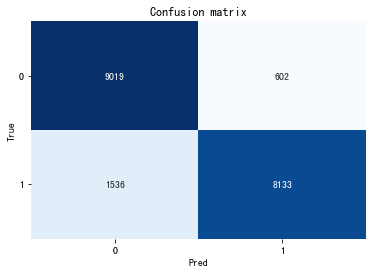

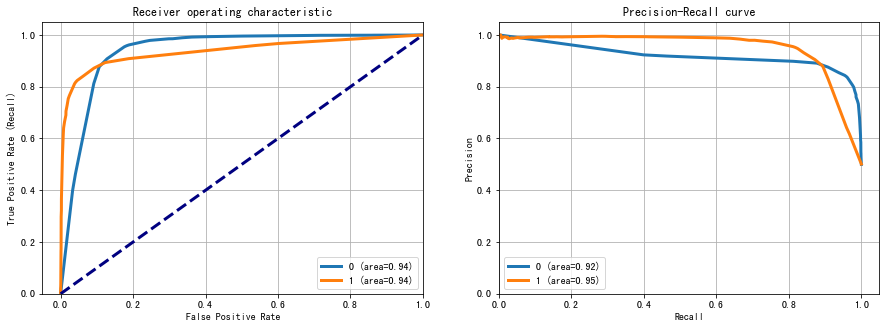

In [346]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all)
precision_all=precision_score(y_test_all, predicted_all)
recall_all=recall_score(y_test_all, predicted_all)

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1, 'Recall':recall_all, 'Precision':precision_all}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 3.2.2 Gradient Boosting (filtered)

In [347]:
model_type="Gradient Boosting (filtered) SMOTE"
gb_filter = GradientBoostingClassifier()
gb_filter.fit(X_train_filter, y_train_filter)

GradientBoostingClassifier()

In [348]:
predicted_filter = gb_filter.predict(X_test_filter)
predicted_prob_filter = gb_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

##### 3.2.2.1 False Negative

In [349]:
result=X_test_filter.copy()
result["corona_result"]=y_test_filter
X_test_filter

,cough,fever,age_60_and_above,gender,test_indication
34771,0,0,0,0,0
68146,1,0,0,1,1
26247,0,0,0,1,0
18022,0,0,0,1,0
36027,0,0,0,1,0
...,...,...,...,...,...
4097,0,0,0,1,0
63301,1,1,0,1,0
26577,0,0,0,0,0
35688,0,0,0,1,0


In [350]:
result["gb_filter"]=predicted_filter
result

,cough,fever,age_60_and_above,gender,test_indication,corona_result,gb_filter
34771,0,0,0,0,0,0,0
68146,1,0,0,1,1,1,1
26247,0,0,0,1,0,0,0
18022,0,0,0,1,0,0,0
36027,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
4097,0,0,0,1,0,0,0
63301,1,1,0,1,0,1,1
26577,0,0,0,0,0,0,0
35688,0,0,0,1,0,0,0


In [351]:
gb_filter_fn=result[(result['corona_result']==1) & (result['gb_filter']==0)]
gb_filter_fn.apply(pd.Series.value_counts)

,cough,fever,age_60_and_above,gender,test_indication,corona_result,gb_filter
0,1344.0,1344.0,1038,522,1344.0,NaN,1344.0
1,NaN,NaN,306,822,NaN,1344.0,NaN


##### 3.2.2.2 False Positive

In [352]:
gb_filter_fp=result[(result['corona_result']==0) & (result['gb_filter']==1)]
gb_filter_fp.apply(pd.Series.value_counts)

,cough,fever,age_60_and_above,gender,test_indication,corona_result,gb_filter
0,104,722,1023,616,1056,1179.0,NaN
1,1075,457,156,563,123,NaN,1179.0


In [353]:
# Get numerical feature importances
importances = list(gb_filter.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_filter, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.53
Variable: fever                Importance: 0.36
Variable: cough                Importance: 0.1
Variable: age_60_and_above     Importance: 0.01
Variable: gender               Importance: 0.01


Accuracy: 0.87
Auc: 0.92
Detail:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      9621
           1       0.88      0.86      0.87      9669

    accuracy                           0.87     19290
   macro avg       0.87      0.87      0.87     19290
weighted avg       0.87      0.87      0.87     19290



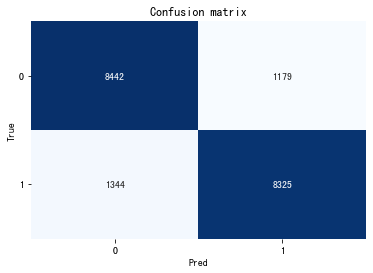

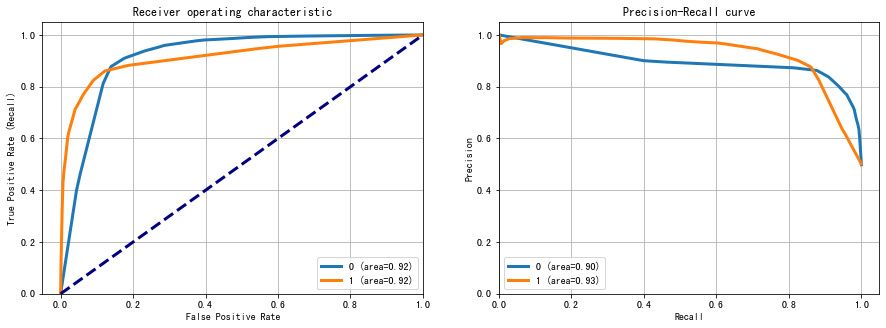

In [354]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter)
precision_filter=precision_score(y_test_filter, predicted_filter)
recall_filter=recall_score(y_test_filter, predicted_filter)

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1, 'Recall': recall_filter, 'Precision':precision_filter
}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 3.3. Decision Tree

#### 3.3.1 Decision Tree (all)

In [355]:
# get the best parameters : max_leaf=5, min_samples=20，accuracy=0.987

def get_mae(max_leaf, min_samples, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes= max_leaf, min_samples_split = min_samples, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    accuracy = accuracy_score(val_y, preds_val)
    print(f"max_leaf = {max_leaf}, min_samples = {min_samples}, accuracy = {accuracy}")
    return(accuracy)

candidate_max_leaf_nodes = [2, 4, 5, 6, 8, 10, 12, 14, 16]
candidate_min_samples = [20, 30, 40]

for num in candidate_max_leaf_nodes:
    for num2 in candidate_min_samples:
        get_mae(num, num2, X_train_all, X_test_all, y_train_all, y_test_all)

max_leaf = 2, min_samples = 20, accuracy = 0.7362882322446863
max_leaf = 2, min_samples = 30, accuracy = 0.7362882322446863
max_leaf = 2, min_samples = 40, accuracy = 0.7362882322446863
max_leaf = 4, min_samples = 20, accuracy = 0.8687402799377916
max_leaf = 4, min_samples = 30, accuracy = 0.8687402799377916
max_leaf = 4, min_samples = 40, accuracy = 0.8687402799377916
max_leaf = 5, min_samples = 20, accuracy = 0.8774494556765163
max_leaf = 5, min_samples = 30, accuracy = 0.8774494556765163
max_leaf = 5, min_samples = 40, accuracy = 0.8774494556765163
max_leaf = 6, min_samples = 20, accuracy = 0.8818558838776568
max_leaf = 6, min_samples = 30, accuracy = 0.8818558838776568
max_leaf = 6, min_samples = 40, accuracy = 0.8818558838776568
max_leaf = 8, min_samples = 20, accuracy = 0.8852255054432349
max_leaf = 8, min_samples = 30, accuracy = 0.8852255054432349
max_leaf = 8, min_samples = 40, accuracy = 0.8852255054432349
max_leaf = 10, min_samples = 20, accuracy = 0.8841368584758943
max_lea

In [356]:
dt_all = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12)
dt_all.fit(X_train_all, y_train_all)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12)

In [357]:
model_type="Decision Tree (all) SMOTE"
predicted_all = dt_all.predict(X_test_all)
predicted_prob_all = dt_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

##### 3.3.1.1 False Negative

In [358]:
result=X_test_all.copy()
result["corona_result"]=y_test_all
X_test_all

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
34771,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1
26247,0,0,0,0,0,0,1,0
18022,0,0,0,0,0,0,1,0
36027,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0
63301,0,0,1,0,0,0,1,0
26577,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0


In [359]:
result["dt_all"]=predicted_all
result

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,dt_all
34771,0,0,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1,1,1
26247,0,0,0,0,0,0,1,0,0,0
18022,0,0,0,0,0,0,1,0,0,0
36027,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0,0,0
63301,0,0,1,0,0,0,1,0,1,1
26577,0,0,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0,0,0


In [360]:
dt_all_fn=result[(result['corona_result']==1) & (result['dt_all']==0)]
dt_all_fn.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,dt_all
0,1032,1599.0,1599.0,1599.0,1599.0,1275,643,1599.0,NaN,1599.0
1,567,NaN,NaN,NaN,NaN,324,956,NaN,1599.0,NaN


##### 3.3.1.2 False Positive

In [361]:
dt_all_fp=result[(result['corona_result']==0) & (result['dt_all']==1)]
dt_all_fp.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,dt_all
0,107,104,551,547,550,484,283,438,561.0,NaN
1,454,457,10,14,11,77,278,123,NaN,561.0


In [362]:
# Get numerical feature importances
importances = list(dt_all.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_all, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.46
Variable: fever                Importance: 0.3
Variable: cough                Importance: 0.1
Variable: head_ache            Importance: 0.08
Variable: sore_throat          Importance: 0.03
Variable: shortness_of_breath  Importance: 0.03
Variable: age_60_and_above     Importance: 0.0
Variable: gender               Importance: 0.0


[Text(0.7, 0.9285714285714286, 'test_indication <= 0.5\nentropy = 1.0\nsamples = 77160\nvalue = [38604, 38556]\nclass = negative'),
 Text(0.6333333333333333, 0.7857142857142857, 'fever <= 0.5\nentropy = 0.925\nsamples = 57665\nvalue = [38023, 19642]\nclass = negative'),
 Text(0.4, 0.6428571428571429, 'cough <= 0.5\nentropy = 0.73\nsamples = 45569\nvalue = [36275, 9294]\nclass = negative'),
 Text(0.26666666666666666, 0.5, 'head_ache <= 0.5\nentropy = 0.585\nsamples = 39228\nvalue = [33722, 5506]\nclass = negative'),
 Text(0.2, 0.35714285714285715, 'sore_throat <= 0.5\nentropy = 0.539\nsamples = 38465\nvalue = [33719, 4746]\nclass = negative'),
 Text(0.13333333333333333, 0.21428571428571427, 'shortness_of_breath <= 0.5\nentropy = 0.515\nsamples = 38098\nvalue = [33713, 4385]\nclass = negative'),
 Text(0.06666666666666667, 0.07142857142857142, 'entropy = 0.498\nsamples = 37836\nvalue = [33704, 4132]\nclass = negative'),
 Text(0.2, 0.07142857142857142, 'entropy = 0.216\nsamples = 262\nvalu

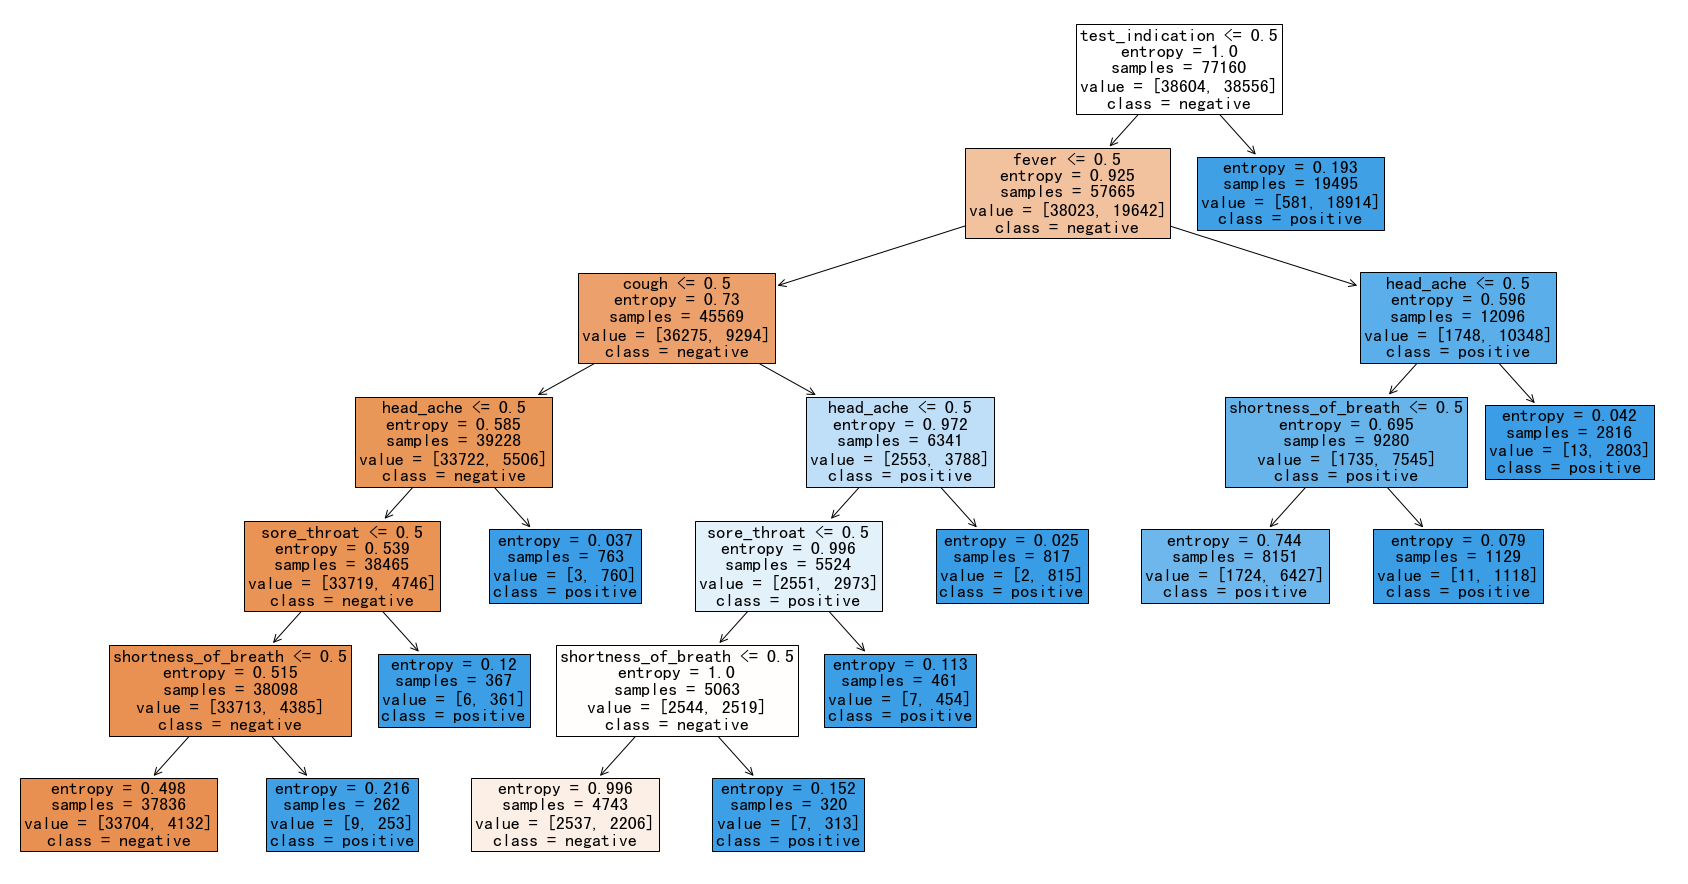

In [363]:
class_name=['negative', 'positive']
fig=plt.figure(figsize=(30, 16))
plot_tree(dt_all, 
          feature_names=features_all,
          class_names=class_name,
          fontsize=18,
          filled=True)

Accuracy: 0.89
Auc: 0.92
Detail:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      9621
           1       0.94      0.83      0.88      9669

    accuracy                           0.89     19290
   macro avg       0.89      0.89      0.89     19290
weighted avg       0.89      0.89      0.89     19290



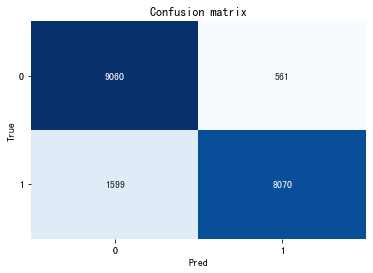

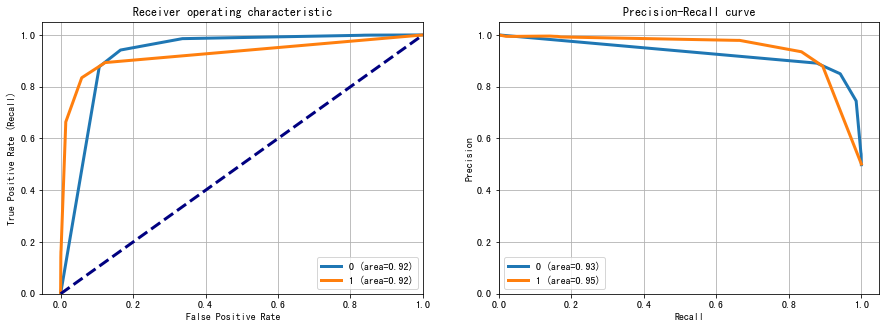

In [364]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all)
precision_all=precision_score(y_test_all, predicted_all)
recall_all=recall_score(y_test_all, predicted_all)

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1 , 'Precision':precision_all,'Recall':recall_all}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 3.3.2 Decision Tree (filtered)

In [365]:
# get the best parameters : max_leaf=5, min_samples=20，accuracy=0.987

def get_mae(max_leaf, min_samples, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes= max_leaf, min_samples_split = min_samples, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    accuracy = accuracy_score(val_y, preds_val)
    print(f"max_leaf = {max_leaf}, min_samples = {min_samples}, accuracy = {accuracy}")
    return(accuracy)

candidate_max_leaf_nodes = [2, 3, 4, 5, 6, 8, 10, 12, 14, 16]
candidate_min_samples = [20, 30, 40]

for num in candidate_max_leaf_nodes:
    for num2 in candidate_min_samples:
        get_mae(num, num2, X_train_filter, X_test_filter, y_train_filter, y_test_filter)

max_leaf = 2, min_samples = 20, accuracy = 0.7373250388802488
max_leaf = 2, min_samples = 30, accuracy = 0.7373250388802488
max_leaf = 2, min_samples = 40, accuracy = 0.7373250388802488
max_leaf = 3, min_samples = 20, accuracy = 0.8501814411612234
max_leaf = 3, min_samples = 30, accuracy = 0.8501814411612234
max_leaf = 3, min_samples = 40, accuracy = 0.8501814411612234
max_leaf = 4, min_samples = 20, accuracy = 0.8692068429237947
max_leaf = 4, min_samples = 30, accuracy = 0.8692068429237947
max_leaf = 4, min_samples = 40, accuracy = 0.8692068429237947
max_leaf = 5, min_samples = 20, accuracy = 0.8692068429237947
max_leaf = 5, min_samples = 30, accuracy = 0.8692068429237947
max_leaf = 5, min_samples = 40, accuracy = 0.8692068429237947
max_leaf = 6, min_samples = 20, accuracy = 0.8692068429237947
max_leaf = 6, min_samples = 30, accuracy = 0.8692068429237947
max_leaf = 6, min_samples = 40, accuracy = 0.8692068429237947
max_leaf = 8, min_samples = 20, accuracy = 0.8692068429237947
max_leaf

In [366]:
dt_filter = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=4)
dt_filter.fit(X_train_filter, y_train_filter)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=4)

In [367]:
model_type="Decision Tree (filterd) SMOTE"
predicted_filter = dt_filter.predict(X_test_filter)
predicted_prob_filter = dt_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

##### 3.3.2.1 False Negative

In [368]:
result=X_test_filter.copy()
result["corona_result"]=y_test_filter

In [369]:
result["dt_filter"]=predicted_filter
result

,cough,fever,age_60_and_above,gender,test_indication,corona_result,dt_filter
34771,0,0,0,0,0,0,0
68146,1,0,0,1,1,1,1
26247,0,0,0,1,0,0,0
18022,0,0,0,1,0,0,0
36027,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
4097,0,0,0,1,0,0,0
63301,1,1,0,1,0,1,1
26577,0,0,0,0,0,0,0
35688,0,0,0,1,0,0,0


In [370]:
dt_filter_fn=result[(result['corona_result']==1) & (result['dt_filter']==0)]
dt_filter_fn.apply(pd.Series.value_counts)

,cough,fever,age_60_and_above,gender,test_indication,corona_result,dt_filter
0,1344.0,1344.0,1038,522,1344.0,NaN,1344.0
1,NaN,NaN,306,822,NaN,1344.0,NaN


##### 3.3.2.1 False Positive

In [371]:
dt_filter_fp=result[(result['corona_result']==0) & (result['dt_filter']==1)]
dt_filter_fp.apply(pd.Series.value_counts)

,cough,fever,age_60_and_above,gender,test_indication,corona_result,dt_filter
0,104,722,1023,616,1056,1179.0,NaN
1,1075,457,156,563,123,NaN,1179.0


In [372]:
# Get numerical feature importances
importances = list(dt_filter.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_filter, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.55
Variable: fever                Importance: 0.34
Variable: cough                Importance: 0.11
Variable: age_60_and_above     Importance: 0.0
Variable: gender               Importance: 0.0


[Text(0.6666666666666666, 0.875, 'test_indication <= 0.5\nentropy = 1.0\nsamples = 77160\nvalue = [38604, 38556]\nclass = negative'),
 Text(0.5, 0.625, 'fever <= 0.5\nentropy = 0.925\nsamples = 57604\nvalue = [38023, 19581]\nclass = negative'),
 Text(0.3333333333333333, 0.375, 'cough <= 0.5\nentropy = 0.733\nsamples = 45651\nvalue = [36275, 9376]\nclass = negative'),
 Text(0.16666666666666666, 0.125, 'entropy = 0.591\nsamples = 39330\nvalue = [33722, 5608]\nclass = negative'),
 Text(0.5, 0.125, 'entropy = 0.973\nsamples = 6321\nvalue = [2553, 3768]\nclass = positive'),
 Text(0.6666666666666666, 0.375, 'entropy = 0.6\nsamples = 11953\nvalue = [1748, 10205]\nclass = positive'),
 Text(0.8333333333333334, 0.625, 'entropy = 0.193\nsamples = 19556\nvalue = [581, 18975]\nclass = positive')]

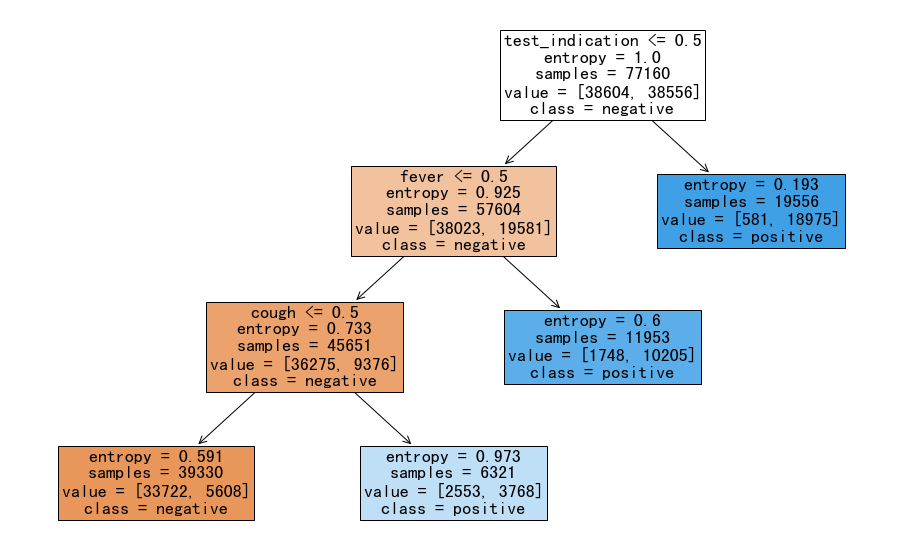

In [373]:
class_name=['negative','positive']
fig=plt.figure(figsize=(16, 10))
plot_tree(dt_filter, 
          feature_names=features_filter,
          class_names=class_name,
          fontsize=18,
          filled=True)

Accuracy: 0.87
Auc: 0.9
Detail:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      9621
           1       0.88      0.86      0.87      9669

    accuracy                           0.87     19290
   macro avg       0.87      0.87      0.87     19290
weighted avg       0.87      0.87      0.87     19290



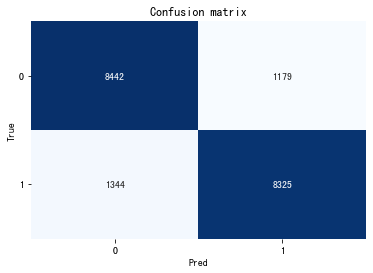

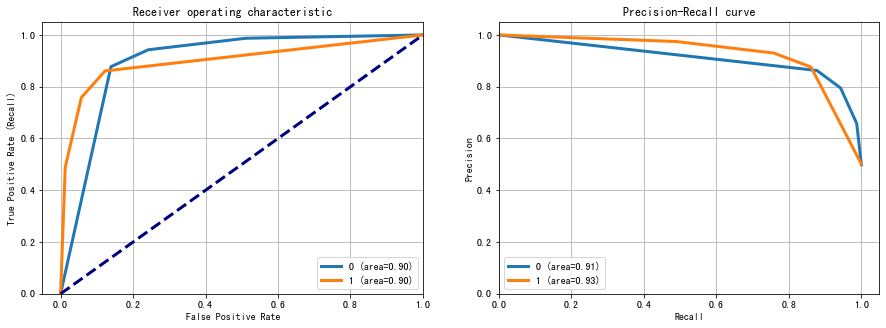

In [374]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter)
precision_filter=precision_score(y_test_filter, predicted_filter)
recall_filter=recall_score(y_test_filter, predicted_filter)
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1, 'Precision':precision_filter, 'Recall': recall_filter}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 3.4. Random Forest

#### 3.4.1 Random Forest (all)

In [375]:
rf_all = ensemble.RandomForestClassifier()
rf_all.fit(X_train_all, y_train_all)

RandomForestClassifier()

In [376]:
model_type="Random Forest (all) SMOTE"
predicted_all = rf_all.predict(X_test_all)
predicted_prob_all = rf_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

##### 3.4.1.1 False Negative

In [377]:
result=X_test_all.copy()
result["corona_result"]=y_test_all
X_test_all

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
34771,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1
26247,0,0,0,0,0,0,1,0
18022,0,0,0,0,0,0,1,0
36027,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0
63301,0,0,1,0,0,0,1,0
26577,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0


In [378]:
result["rf_all"]=predicted_all
result

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,rf_all
34771,0,0,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1,1,1
26247,0,0,0,0,0,0,1,0,0,0
18022,0,0,0,0,0,0,1,0,0,0
36027,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0,0,0
63301,0,0,1,0,0,0,1,0,1,1
26577,0,0,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0,0,0


In [379]:
rf_all_fn=result[(result['corona_result']==1) & (result['rf_all']==0)]
rf_all_fn.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,rf_all
0,1032,1280.0,1280.0,1280.0,1280.0,1019,643,1280.0,NaN,1280.0
1,248,NaN,NaN,NaN,NaN,261,637,NaN,1280.0,NaN


##### 3.4.1.2 False Positive

In [380]:
rf_all_fp=result[(result['corona_result']==0) & (result['rf_all']==1)]
rf_all_fp.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,rf_all
0,107,390,837,833,836,729,283,724,847.0,NaN
1,740,457,10,14,11,118,564,123,NaN,847.0


In [381]:
# Get numerical feature importances
importances = list(rf_all.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_all, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.37
Variable: fever                Importance: 0.25
Variable: cough                Importance: 0.15
Variable: head_ache            Importance: 0.11
Variable: sore_throat          Importance: 0.06
Variable: shortness_of_breath  Importance: 0.04
Variable: age_60_and_above     Importance: 0.01
Variable: gender               Importance: 0.01


Accuracy: 0.89
Auc: 0.94
Detail:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      9621
           1       0.91      0.87      0.89      9669

    accuracy                           0.89     19290
   macro avg       0.89      0.89      0.89     19290
weighted avg       0.89      0.89      0.89     19290



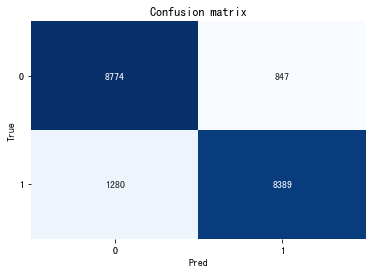

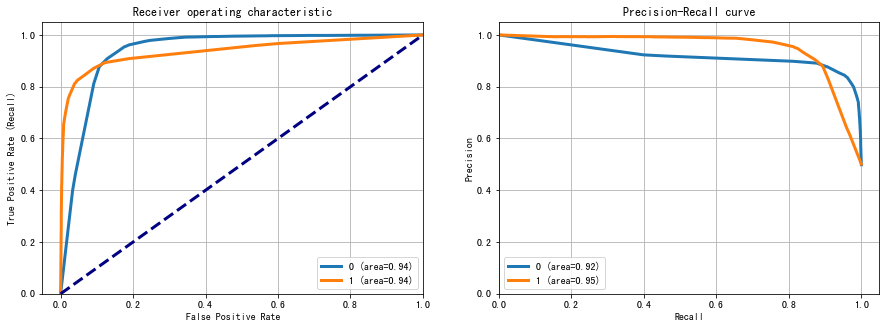

In [382]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all)
precision_all=precision_score(y_test_all, predicted_all)
recall_all=recall_score(y_test_all, predicted_all)
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1, 'Precision':precision_all, 'Recall':recall_all }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 3.4.2 Random Forest (filtered)

In [383]:
rf_filter = ensemble.RandomForestClassifier()
rf_filter.fit(X_train_filter, y_train_filter)

RandomForestClassifier()

In [384]:
model_type="Random Forest (filered) SMOTE"
predicted_filter = rf_filter.predict(X_test_filter)
predicted_prob_filter = rf_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

##### 3.4.2.1 False Negative

In [385]:
result=X_test_filter.copy()
result["corona_result"]=y_test_filter

In [386]:
result["rf_filter"]=predicted_filter
result

,cough,fever,age_60_and_above,gender,test_indication,corona_result,rf_filter
34771,0,0,0,0,0,0,0
68146,1,0,0,1,1,1,1
26247,0,0,0,1,0,0,0
18022,0,0,0,1,0,0,0
36027,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
4097,0,0,0,1,0,0,0
63301,1,1,0,1,0,1,1
26577,0,0,0,0,0,0,0
35688,0,0,0,1,0,0,0


In [387]:
rf_filter_fn=result[(result['corona_result']==1) & (result['rf_filter']==0)]
rf_filter_fn.apply(pd.Series.value_counts)

,cough,fever,age_60_and_above,gender,test_indication,corona_result,rf_filter
0,1344.0,1344.0,1038,522,1344.0,NaN,1344.0
1,NaN,NaN,306,822,NaN,1344.0,NaN


##### 3.4.2.2 False Positive

In [388]:
rf_filter_fp=result[(result['corona_result']==0) & (result['rf_filter']==1)]
rf_filter_fp.apply(pd.Series.value_counts)

,cough,fever,age_60_and_above,gender,test_indication,corona_result,rf_filter
0,104,722,1023,616,1056,1179.0,NaN
1,1075,457,156,563,123,NaN,1179.0


In [389]:
# Get numerical feature importances
importances = list(rf_filter.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_filter, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.46
Variable: fever                Importance: 0.33
Variable: cough                Importance: 0.19
Variable: age_60_and_above     Importance: 0.01
Variable: gender               Importance: 0.01


Accuracy: 0.87
Auc: 0.92
Detail:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      9621
           1       0.88      0.86      0.87      9669

    accuracy                           0.87     19290
   macro avg       0.87      0.87      0.87     19290
weighted avg       0.87      0.87      0.87     19290



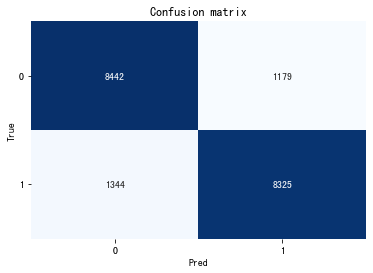

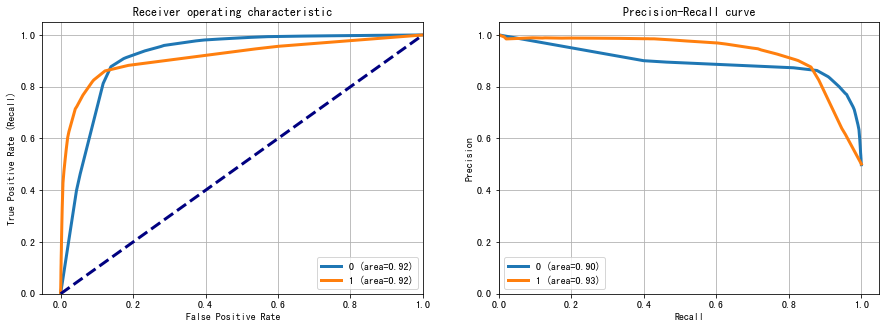

In [390]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter)
precision_filter=precision_score(y_test_filter, predicted_filter)
recall_filter=recall_score(y_test_filter, predicted_filter)
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1, 'Precision':precision_filter, 'Recall':recall_filter}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 3.5. XGBoost

#### 3.5.1 XGBoost (all)

In [391]:
xgb_all = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,           # 树的个数-10棵树建立xgboost
                      max_depth=10,               # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=1,               # 所有样本建立决策树
                      colsample_btree=1,         # 所有特征建立决策树
                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
                      random_state=42,           # 随机数
                      slient = 0
                      )
# xgb_all=XGBClassifier()
xgb_all.fit(X_train_all,y_train_all)

C:\Users\betty\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              slient=0, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [392]:
model_type="XGBoost (all) SMOTE"
predicted_all = xgb_all.predict(X_test_all)
predicted_prob_all = xgb_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

##### 3.5.1.1 False Negative

In [393]:
result=X_test_all.copy()
result["corona_result"]=y_test_all
X_test_all

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
34771,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1
26247,0,0,0,0,0,0,1,0
18022,0,0,0,0,0,0,1,0
36027,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0
63301,0,0,1,0,0,0,1,0
26577,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0


In [394]:
result["xgb_all"]=predicted_all
result

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,xgb_all
34771,0,0,0,0,0,0,0,0,0,0
68146,0,1,0,0,0,0,1,1,1,1
26247,0,0,0,0,0,0,1,0,0,0
18022,0,0,0,0,0,0,1,0,0,0
36027,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4097,0,0,0,0,0,0,1,0,0,0
63301,0,0,1,0,0,0,1,0,1,1
26577,0,0,0,0,0,0,0,0,0,0
35688,0,0,0,0,0,0,1,0,0,0


In [395]:
xgb_all_fn=result[(result['corona_result']==1) & (result['xgb_all']==0)]
xgb_all_fn.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,xgb_all
0,1032,1280.0,1280.0,1280.0,1280.0,1019,643,1280.0,NaN,1280.0
1,248,NaN,NaN,NaN,NaN,261,637,NaN,1280.0,NaN


##### 3.5.1.2 False Positive

In [396]:
xgb_all_fp=result[(result['corona_result']==0) & (result['xgb_all']==1)]
xgb_all_fp.apply(pd.Series.value_counts)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,corona_result,xgb_all
0,107,390,837,833,836,729,283,724,847.0,NaN
1,740,457,10,14,11,118,564,123,NaN,847.0


In [397]:
# Get numerical feature importances
importances = list(xgb_all.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_all, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.6800000071525574
Variable: fever                Importance: 0.23000000417232513
Variable: cough                Importance: 0.05000000074505806
Variable: head_ache            Importance: 0.029999999329447746
Variable: sore_throat          Importance: 0.009999999776482582
Variable: shortness_of_breath  Importance: 0.009999999776482582
Variable: age_60_and_above     Importance: 0.0
Variable: gender               Importance: 0.0


Accuracy: 0.89
Auc: 0.94
Detail:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      9621
           1       0.91      0.87      0.89      9669

    accuracy                           0.89     19290
   macro avg       0.89      0.89      0.89     19290
weighted avg       0.89      0.89      0.89     19290



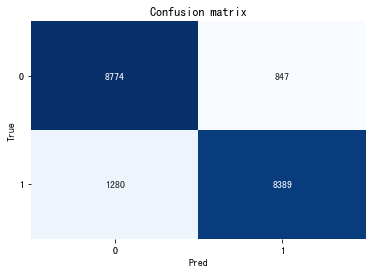

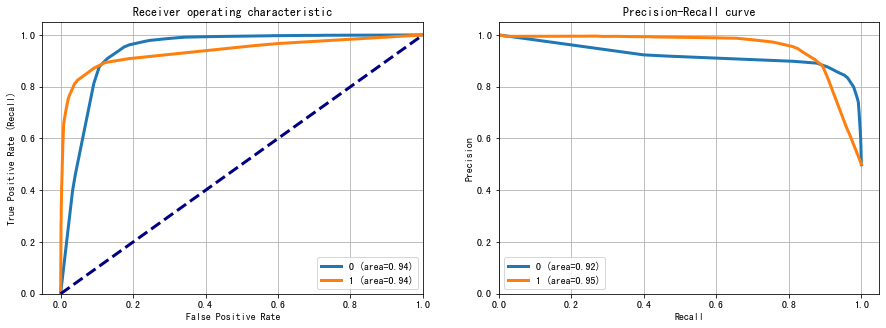

In [398]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all)
precision_all=precision_score(y_test_all, predicted_all)
recall_all=recall_score(y_test_all, predicted_all)
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1, 'Precision':precision_all, 'Recall':recall_all }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 3.5.2 XGBoost (filtered)

In [399]:
xgb_filter = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,           # 树的个数-10棵树建立xgboost
                      max_depth=10,               # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=1,               # 所有样本建立决策树
                      colsample_btree=1,         # 所有特征建立决策树
                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
                      random_state=42,           # 随机数
                      slient = 0
                      )
# xgb_filter=XGBClassifier()
xgb_filter.fit(X_train_filter,y_train_filter)

C:\Users\betty\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              slient=0, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [400]:
model_type="XGBoost (filered) SMOTE"
predicted_filter = xgb_filter.predict(X_test_filter)
predicted_prob_filter = xgb_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

##### 3.5.2.1 False Negative

In [401]:
result=X_test_filter.copy()
result["corona_result"]=y_test_filter

In [402]:
result["xgb_filter"]=predicted_filter
result

,cough,fever,age_60_and_above,gender,test_indication,corona_result,xgb_filter
34771,0,0,0,0,0,0,0
68146,1,0,0,1,1,1,1
26247,0,0,0,1,0,0,0
18022,0,0,0,1,0,0,0
36027,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
4097,0,0,0,1,0,0,0
63301,1,1,0,1,0,1,1
26577,0,0,0,0,0,0,0
35688,0,0,0,1,0,0,0


In [403]:
xgb_filter_fn=result[(result['corona_result']==1) & (result['xgb_filter']==0)]
xgb_filter_fn.apply(pd.Series.value_counts)

,cough,fever,age_60_and_above,gender,test_indication,corona_result,xgb_filter
0,1344.0,1344.0,1038,522,1344.0,NaN,1344.0
1,NaN,NaN,306,822,NaN,1344.0,NaN


##### 3.5.2.2 False Positive

In [404]:
# Get numerical feature importances
importances = list(xgb_filter.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_filter, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.7300000190734863
Variable: fever                Importance: 0.2199999988079071
Variable: cough                Importance: 0.05000000074505806
Variable: age_60_and_above     Importance: 0.0
Variable: gender               Importance: 0.0


In [405]:
xgb_filter_fp=result[(result['corona_result']==0) & (result['xgb_filter']==1)]
xgb_filter_fp.apply(pd.Series.value_counts)

,cough,fever,age_60_and_above,gender,test_indication,corona_result,xgb_filter
0,104,722,1023,616,1056,1179.0,NaN
1,1075,457,156,563,123,NaN,1179.0


Accuracy: 0.87
Auc: 0.92
Detail:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      9621
           1       0.88      0.86      0.87      9669

    accuracy                           0.87     19290
   macro avg       0.87      0.87      0.87     19290
weighted avg       0.87      0.87      0.87     19290



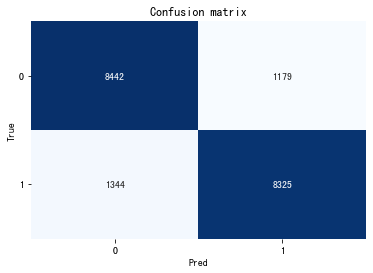

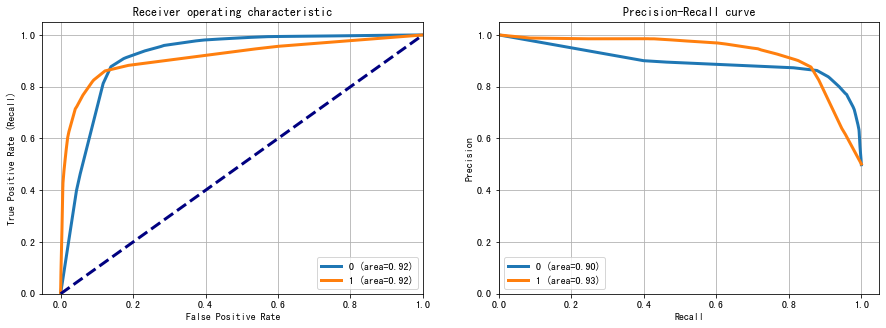

In [406]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter)
precision_filter=precision_score(y_test_filter, predicted_filter)
recall_filter=recall_score(y_test_filter, predicted_filter)
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1, 'Precision':precision_filter, 'Recall':recall_filter}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 3.6. 比較

In [407]:
result_df.sort_values(by=['F1-score'], ascending=False)

,model_type,Accuracy,AUC,F1-score,Precision,Recall
5,Random Forest (all) SMOTE,0.889736,0.937186,0.887490,0.908294,0.867618
7,XGBoost (all) SMOTE,0.889736,0.937256,0.887490,0.908294,0.867618
1,Gradient Boosting (all) SMOTE,0.889165,0.937088,0.883830,0.931082,0.841142
3,Decision Tree (all) SMOTE,0.888025,0.924628,0.881967,0.935002,0.834626
2,Gradient Boosting (filtered) SMOTE,0.869207,0.915107,0.868409,0.875947,0.860999
4,Decision Tree (filterd) SMOTE,0.869207,0.900170,0.868409,0.875947,0.860999
6,Random Forest (filered) SMOTE,0.869207,0.915142,0.868409,0.875947,0.860999
8,XGBoost (filered) SMOTE,0.869207,0.915021,0.868409,0.875947,0.860999
0,Gradient Boosting (all),0.959072,0.934463,0.734719,0.862267,0.640043


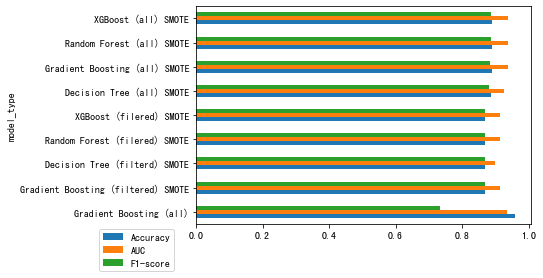

In [408]:
result_df.sort_values(by=['F1-score'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC", "F1-score"])
plt.legend(bbox_to_anchor=(-0.05,0))